In [1]:
import tensorflow as tf 
import tensorflow_probability as tfp
from tensorflow.keras.datasets import mnist

In [15]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import argparse
import random
import os

tfd = tfp.distributions

In [41]:
import importlib
import custom_layers
import utilities

In [8]:
# Hyperparameter setup
learning_rate = 0.001
epochs = 100
batch_size = 128
num_classes = 10
num_samples = 1

n_samples = 5000 # number of MNIST samples

In [9]:
I = np.eye(num_classes)
x_train_S, y_train_S, x_test, y_test = utilities.load_mnist(n_samples, square=False, conv=False)
y_train_S = y_train_S.astype('int32')
y_test = y_test.astype('int32')

N = int(n_samples/2)

x_val = x_train_S[N:]
y_val = y_train_S[N:]

x_train = x_train_S[:N]
y_train = y_train_S[:N]

# Add output noise to important class
R = int(.5*N)
r_ind = random.sample(range(0,N),R)
r_class = np.random.randint(0,num_classes,R)
y_train[r_ind] = r_class

train_samples = N

x_train shape: (5000, 784)
5000 train samples
10000 test samples


In [48]:
digits = [3,8]
np.set_printoptions(precision=3)
L = np.copy(I)
L[np.where(I==0)] = 1
# L[[3,8]] = 0.7 # Select more important rows with lower loss in prediction
L[np.where(I==1)] = 0

loss_mat = L
M = 1.0001

print("         TRUTH\n" )
string = 'PRED'
for i in range(num_classes):
    if i < 4:
        print(string[i],'  ',str(i),': ',M - loss_mat[i])
    else:
        print('    ',str(i),': ',M - loss_mat[i])
        
# Set up weight for weighted cross entropy

class_weight = np.ones((num_classes))
class_weight[digits] = 1.4

print(loss_mat)

         TRUTH

P    0 :  [1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
R    1 :  [1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
E    2 :  [1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
D    3 :  [1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
     4 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
     5 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04]
     6 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04]
     7 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04]
     8 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04]
     9 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]

In [55]:
loss_mat_t = tf.constant(loss_mat, dtype=tf.float32)

In [72]:
# For reproduceable results
importlib.reload(custom_layers)
importlib.reload(utilities)
# np.random.seed(1337)

# Scale the KL term from the probabilistic layers for per-datapoint ELBO. 
# KL term added internally as a regularization term.

scaled_kl = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(train_samples, tf.float32)


x_input =  tf.keras.Input((x_train.shape[1:]), name = 'x_input')
y_input =  tf.keras.Input((1,), name = 'y_input')
h_input =  tf.keras.Input((1,), name = 'h_input')

logits = custom_layers.LCSoftmax( 
    10,
    M = M,
    loss_mat = loss_mat_t,
    kernel_divergence_fn=scaled_kl)([x_input, y_input, h_input])

model = tf.keras.Model([x_input, y_input, h_input], logits)
model.compile(loss=None, optimizer='adam')

In [73]:
h_train = y_train
h_test = y_test
h_val = y_val

history_model = []
for epoch in range(epochs):
    history_epoch = model.fit([x_train, y_train, h_train],
                 batch_size=batch_size,
                 epochs=1,
                 verbose=1,
                 validation_data=([x_val, y_val, h_val], None),
                 callbacks=[model_checkpoint])
#     T = 10
#     yt_hat = np.array([lc_model.predict([x_train,H_x]) for _ in range(T)])
#     H_x = lcbnn.optimal_h(yt_hat,loss_mat)
    h_train = np.argmax(model.predict([x_train, y_train, h_train]), -1)
    history_model.append(history_epoch)
       

Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 1s 362us/step - loss: 13.0694 - val_loss: 12.3468
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 38us/step - loss: 11.9364 - val_loss: 11.7814
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 31us/step - loss: 11.6451 - val_loss: 11.3817
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 40us/step - loss: 11.3736 - val_loss: 11.1891
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 29us/step - loss: 11.1752 - val_loss: 10.7450
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 41us/step - loss: 10.9705 - val_loss: 10.4143
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==================

2500/2500 [==============================] - 0s 28us/step - loss: 8.2604 - val_loss: 7.4735
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 42us/step - loss: 8.2283 - val_loss: 7.4580
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 41us/step - loss: 8.2307 - val_loss: 7.3980
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 82us/step - loss: 8.1505 - val_loss: 7.3812
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 87us/step - loss: 8.1013 - val_loss: 7.3377
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 42us/step - loss: 8.0701 - val_loss: 7.3198
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 39us/step - loss: 8.0318 - val_loss: 7.3347
Train on

In [62]:
model_ove.evaluate([x_test, y_test])

10000/10000 [==============================] - 1s 81us/step


6.357708633422852

In [64]:
#  Softmax model

T = 1
yt_hat_std = np.array([model.predict([x_test]) for _ in range(T)])
H_x_test_std = utilities.optimal_h(yt_hat_std,loss_mat) 
acc_std = accuracy_score(y_test, H_x_test_std)
loss_std = np.mean(loss_mat[y_test, H_x_test_std])
print('Standard:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)


# OVE lower bound to softmax model

T = 10 
yt_hat_std = np.array([model_ove.predict([x_test, y_test]) for _ in range(T)])
H_x_test_ove = utilities.optimal_h(yt_hat_std,loss_mat) 
acc_std = accuracy_score(y_test, H_x_test_ove)
loss_std = np.mean(loss_mat[y_test, H_x_test_ove])
print('\nOVE:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)


Standard:

Accuracy on optimal decision:  0.6913
Expected loss:  0.25967999999999997

OVE:

Accuracy on optimal decision:  0.7821
Expected loss:  0.2095


Normalized confusion matrix
[[0.86 0.01 0.02 0.   0.   0.02 0.05 0.02 0.   0.02]
 [0.   0.96 0.01 0.   0.01 0.01 0.01 0.   0.   0.  ]
 [0.03 0.07 0.75 0.   0.03 0.02 0.06 0.03 0.01 0.02]
 [0.04 0.04 0.14 0.2  0.05 0.23 0.07 0.17 0.01 0.07]
 [0.01 0.02 0.01 0.   0.8  0.01 0.02 0.03 0.   0.1 ]
 [0.03 0.02 0.01 0.   0.03 0.76 0.05 0.06 0.   0.03]
 [0.02 0.02 0.02 0.   0.02 0.04 0.85 0.02 0.   0.02]
 [0.02 0.04 0.03 0.   0.02 0.   0.01 0.79 0.   0.09]
 [0.06 0.14 0.05 0.   0.1  0.23 0.09 0.07 0.15 0.11]
 [0.02 0.01 0.01 0.   0.1  0.01 0.01 0.07 0.   0.76]]
Normalized confusion matrix
[[8.56e-01 1.02e-03 6.12e-03 4.29e-02 3.06e-03 7.14e-03 1.73e-02 1.02e-03
  6.43e-02 1.02e-03]
 [0.00e+00 9.20e-01 3.52e-03 8.81e-03 0.00e+00 8.81e-04 3.52e-03 0.00e+00
  6.34e-02 0.00e+00]
 [7.75e-03 1.45e-02 7.65e-01 5.43e-02 1.07e-02 9.69e-04 9.69e-03 8.72e-03
  1.28e-01 9.69e-04]
 [0.00e+00 0.00e+00 1.29e-02 8.27e-01 9.90e-04 3.27e-02 7.92e-03 3.07e-02
  8.32e-02 4.95e-03]
 [1.02e-03 1.32e-02 5.09e-03 3.36

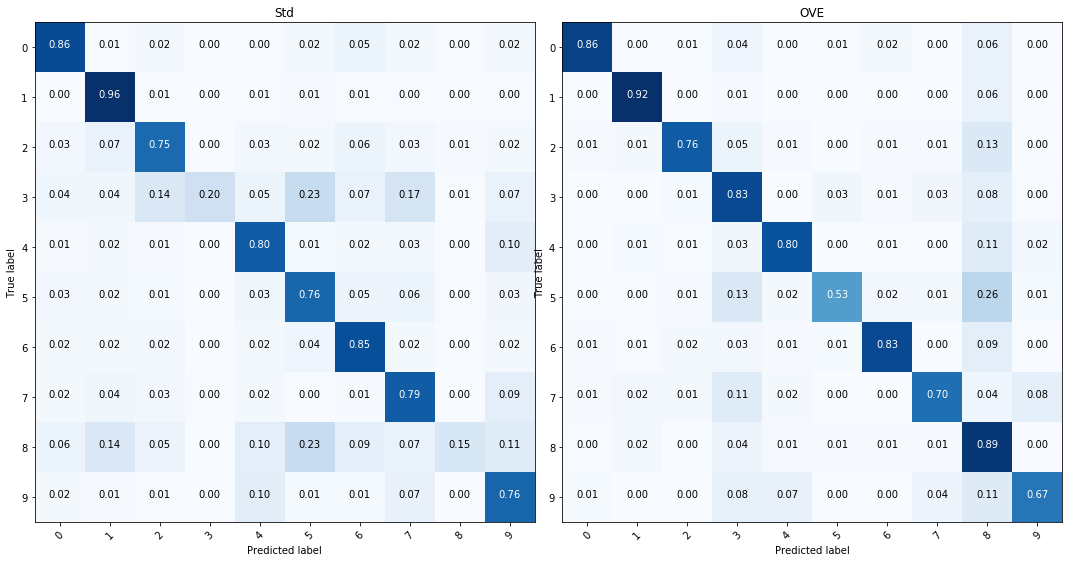

In [65]:
plt.rcParams['figure.figsize'] = (15, 15) # Width and height

classes = ['0','1','2','3','4','5','6','7','8','9']


cnf_matrix_std = confusion_matrix(y_test.astype('float'),np.round(H_x_test_std))
np.set_printoptions(precision=2)
cnf_matrix_ove = confusion_matrix(y_test.astype('float'),np.round(H_x_test_ove))
np.set_printoptions(precision=2)
# cnf_matrix_we = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_we.reshape((H_x_test.shape[0],))))
# np.set_printoptions(precision=2)

plt.subplot(121)
# Plot normalized confusion matrix
utilities.plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Std')
plt.subplot(122)

utilities.plot_confusion_matrix(cnf_matrix_ove, classes=classes, normalize=True,
                      title='OVE')